# CO2 Emission Prediction Model
## Maritime Shipping Emissions Analysis

This notebook builds a machine learning model to predict CO2 emissions from ships based on various operational parameters.

## 1. Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Load and Explore Data

In [4]:
# Load the dataset
df = pd.read_csv('data/mindx test dataset.csv')

# Display basic information
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
df.head()

Dataset Shape: (1440, 10)

First few rows:


,ship_id,ship_type,route_id,month,distance,fuel_type,fuel_consumption,CO2_emissions,weather_conditions,engine_efficiency
0,NG001,Oil Service Boat,Warri-Bonny,January,132.26,HFO,3779.77,10625.76,Stormy,92.14
1,NG001,Oil Service Boat,Port Harcourt-Lagos,February,128.52,HFO,4461.44,12779.73,Moderate,92.98
2,NG001,Oil Service Boat,Port Harcourt-Lagos,March,67.30,HFO,1867.73,5353.01,Calm,87.61
3,NG001,Oil Service Boat,Port Harcourt-Lagos,April,71.68,Diesel,2393.51,6506.52,Stormy,87.42
4,NG001,Oil Service Boat,Lagos-Apapa,May,134.32,HFO,4267.19,11617.03,Calm,85.61


In [5]:
# Data info
print("Dataset Information:")
df.info()

print("\nStatistical Summary:")
df.describe()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ship_id             1440 non-null   object 
 1   ship_type           1440 non-null   object 
 2   route_id            1440 non-null   object 
 3   month               1440 non-null   object 
 4   distance            1440 non-null   float64
 5   fuel_type           1440 non-null   object 
 6   fuel_consumption    1440 non-null   float64
 7   CO2_emissions       1440 non-null   float64
 8   weather_conditions  1440 non-null   object 
 9   engine_efficiency   1440 non-null   float64
dtypes: float64(4), object(6)
memory usage: 112.6+ KB

Statistical Summary:


,distance,fuel_consumption,CO2_emissions,engine_efficiency
count,1440.000000,1440.000000,1440.000000,1440.000000
mean,151.753354,4844.246535,13365.454882,82.582924
std,108.472230,4892.352813,13567.650118,7.158289
min,20.080000,237.880000,615.680000,70.010000
25%,79.002500,1837.962500,4991.485000,76.255000
50%,123.465000,3060.880000,8423.255000,82.775000
75%,180.780000,4870.675000,13447.120000,88.862500
max,498.550000,24648.520000,71871.210000,94.980000


In [6]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())

# Check unique values for categorical columns
print("\nUnique Values in Categorical Columns:")
print(f"Ship Types: {df['ship_type'].nunique()} - {df['ship_type'].unique()}")
print(f"Fuel Types: {df['fuel_type'].nunique()} - {df['fuel_type'].unique()}")
print(f"Weather Conditions: {df['weather_conditions'].nunique()} - {df['weather_conditions'].unique()}")
print(f"Routes: {df['route_id'].nunique()}")

Missing Values:
ship_id               0
ship_type             0
route_id              0
month                 0
distance              0
fuel_type             0
fuel_consumption      0
CO2_emissions         0
weather_conditions    0
engine_efficiency     0
dtype: int64

Unique Values in Categorical Columns:
Ship Types: 4 - ['Oil Service Boat' 'Fishing Trawler' 'Surfer Boat' 'Tanker Ship']
Fuel Types: 2 - ['HFO' 'Diesel']
Weather Conditions: 3 - ['Stormy' 'Moderate' 'Calm']
Routes: 4


## 3. Exploratory Data Analysis (EDA)

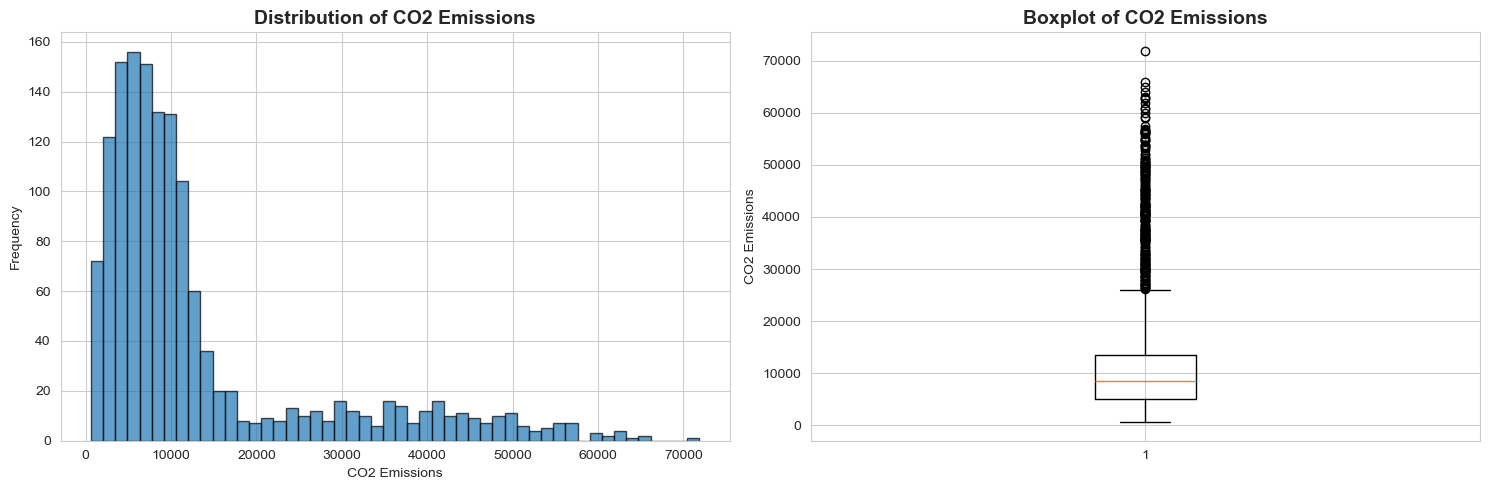

In [7]:
# Distribution of CO2 emissions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(df['CO2_emissions'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of CO2 Emissions', fontsize=14, fontweight='bold')
axes[0].set_xlabel('CO2 Emissions')
axes[0].set_ylabel('Frequency')

axes[1].boxplot(df['CO2_emissions'])
axes[1].set_title('Boxplot of CO2 Emissions', fontsize=14, fontweight='bold')
axes[1].set_ylabel('CO2 Emissions')

plt.tight_layout()
plt.show()

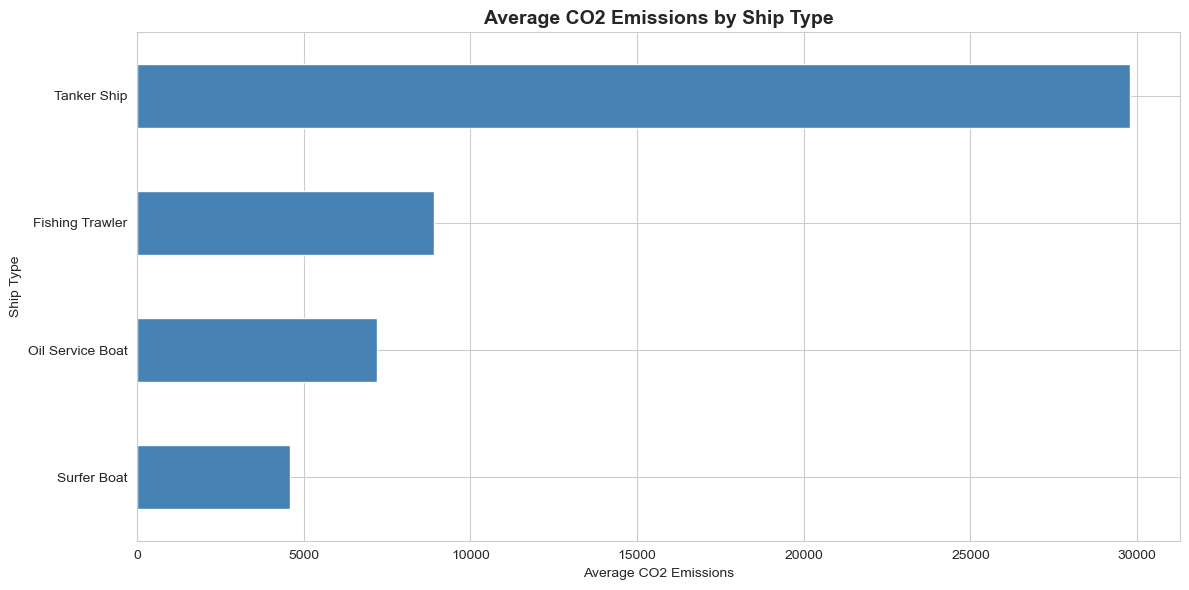

In [8]:
# CO2 emissions by ship type
plt.figure(figsize=(12, 6))
df.groupby('ship_type')['CO2_emissions'].mean().sort_values().plot(kind='barh', color='steelblue')
plt.title('Average CO2 Emissions by Ship Type', fontsize=14, fontweight='bold')
plt.xlabel('Average CO2 Emissions')
plt.ylabel('Ship Type')
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

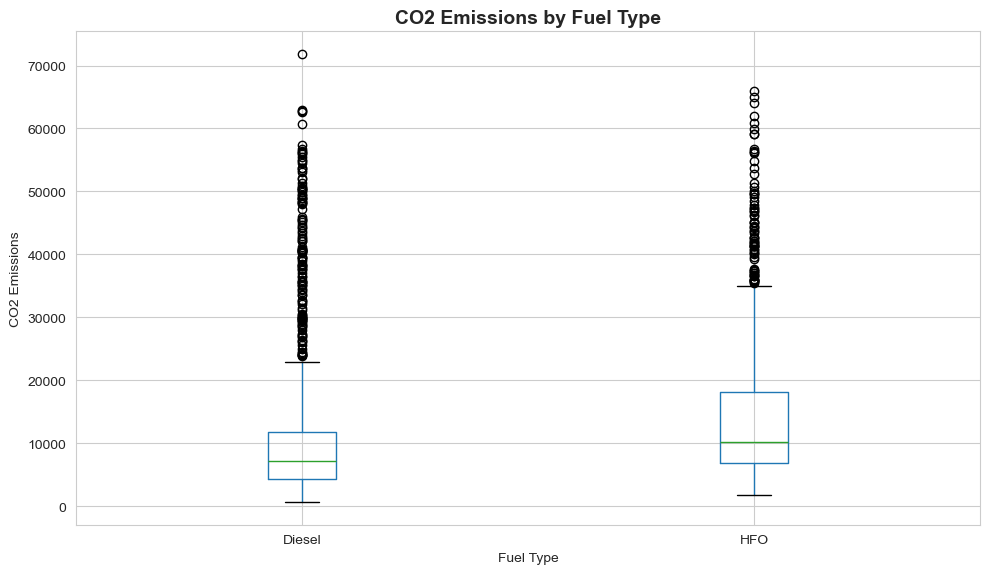

In [9]:
# CO2 emissions by fuel type
plt.figure(figsize=(10, 6))
df.boxplot(column='CO2_emissions', by='fuel_type', figsize=(10, 6))
plt.title('CO2 Emissions by Fuel Type', fontsize=14, fontweight='bold')
plt.suptitle('')
plt.xlabel('Fuel Type')
plt.ylabel('CO2 Emissions')
plt.tight_layout()
plt.show()

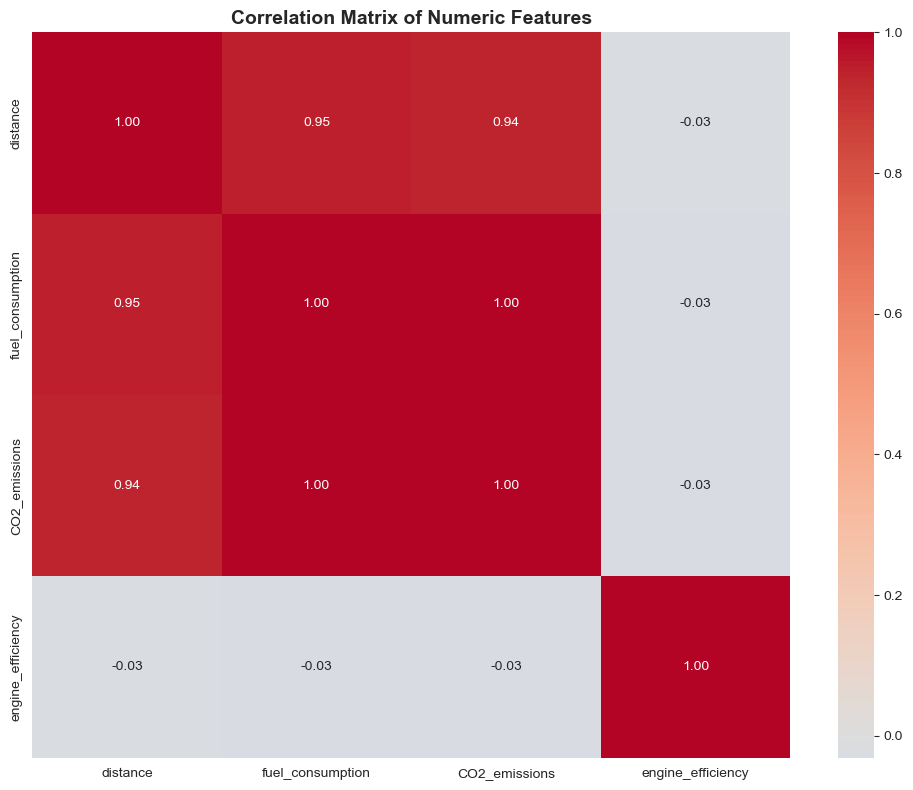


Correlation with CO2 Emissions:
CO2_emissions        1.000000
fuel_consumption     0.997247
distance             0.942657
engine_efficiency   -0.030151
Name: CO2_emissions, dtype: float64


In [10]:
# Correlation analysis
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix of Numeric Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nCorrelation with CO2 Emissions:")
print(correlation_matrix['CO2_emissions'].sort_values(ascending=False))

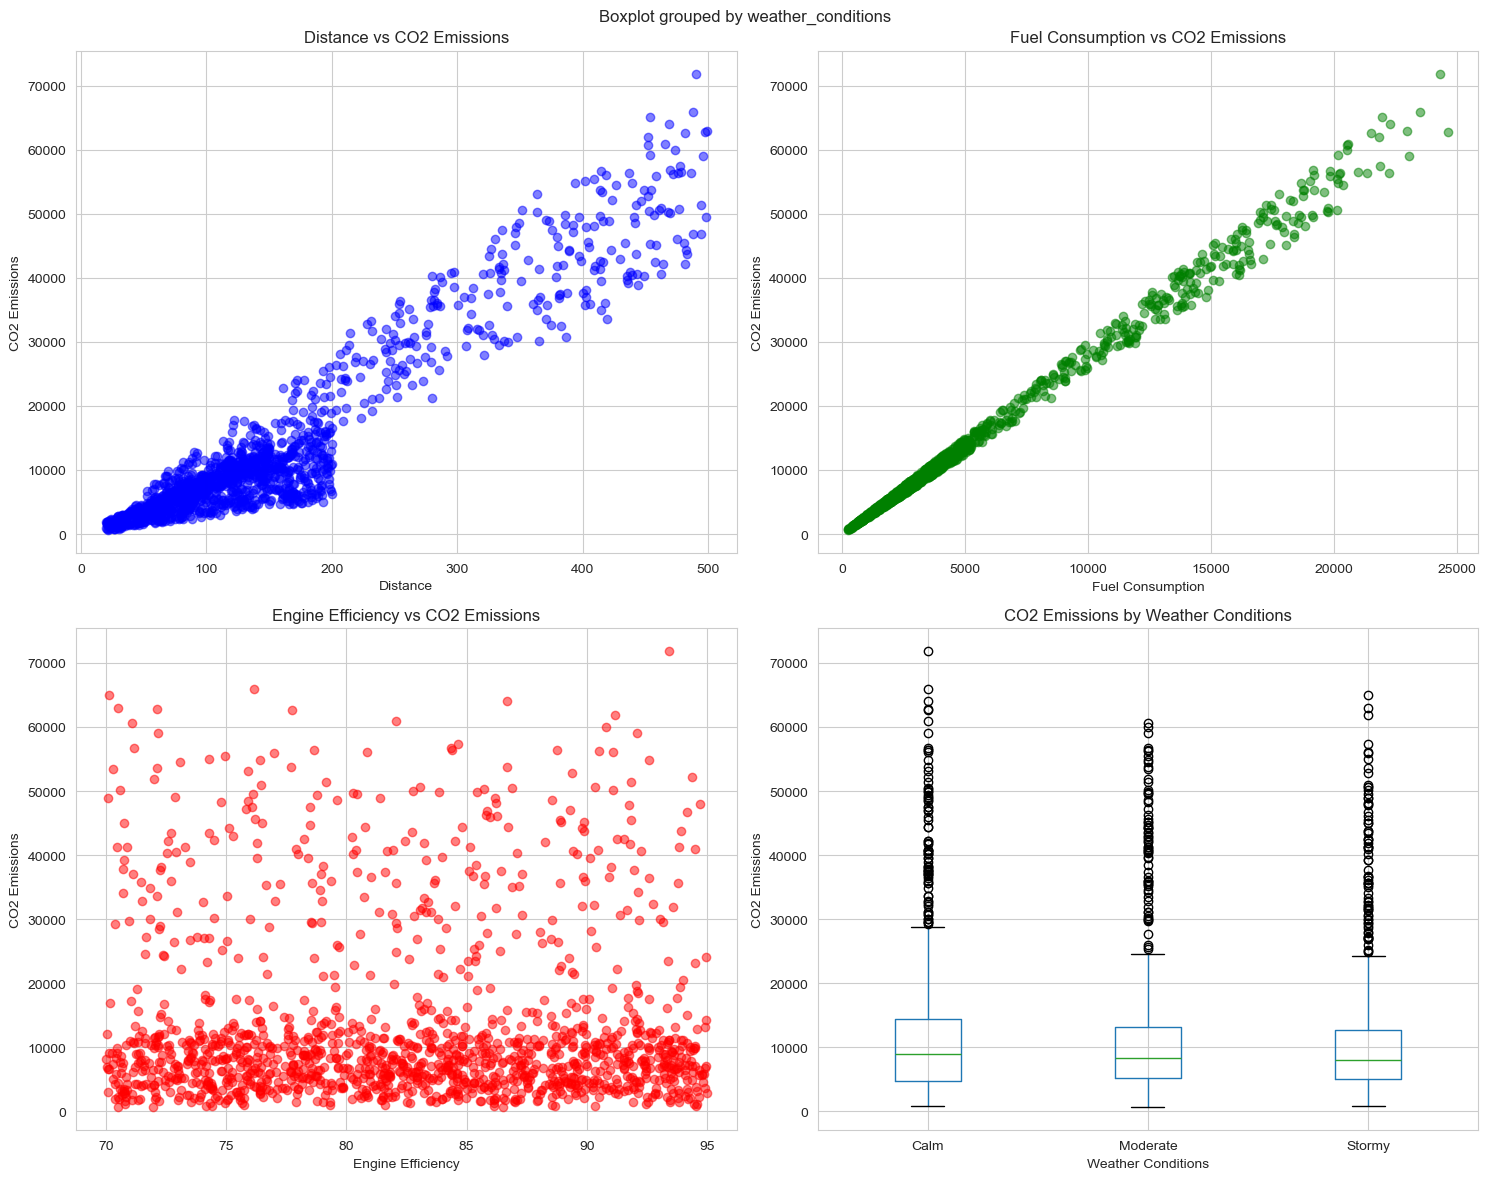

In [11]:
# Scatter plots for key relationships
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].scatter(df['distance'], df['CO2_emissions'], alpha=0.5, c='blue')
axes[0, 0].set_title('Distance vs CO2 Emissions')
axes[0, 0].set_xlabel('Distance')
axes[0, 0].set_ylabel('CO2 Emissions')

axes[0, 1].scatter(df['fuel_consumption'], df['CO2_emissions'], alpha=0.5, c='green')
axes[0, 1].set_title('Fuel Consumption vs CO2 Emissions')
axes[0, 1].set_xlabel('Fuel Consumption')
axes[0, 1].set_ylabel('CO2 Emissions')

axes[1, 0].scatter(df['engine_efficiency'], df['CO2_emissions'], alpha=0.5, c='red')
axes[1, 0].set_title('Engine Efficiency vs CO2 Emissions')
axes[1, 0].set_xlabel('Engine Efficiency')
axes[1, 0].set_ylabel('CO2 Emissions')

# Weather conditions impact
df.boxplot(column='CO2_emissions', by='weather_conditions', ax=axes[1, 1])
axes[1, 1].set_title('CO2 Emissions by Weather Conditions')
axes[1, 1].set_xlabel('Weather Conditions')
axes[1, 1].set_ylabel('CO2 Emissions')

plt.tight_layout()
plt.show()

## 4. Data Preprocessing

In [12]:
# Create a copy for preprocessing
df_processed = df.copy()

# Encode categorical variables
label_encoders = {}
categorical_cols = ['ship_type', 'route_id', 'month', 'fuel_type', 'weather_conditions']

for col in categorical_cols:
    le = LabelEncoder()
    df_processed[col + '_encoded'] = le.fit_transform(df_processed[col])
    label_encoders[col] = le
    print(f"Encoded {col}: {len(le.classes_)} unique values")

print("\nLabel encoders saved for future use.")

Encoded ship_type: 4 unique values
Encoded route_id: 4 unique values
Encoded month: 12 unique values
Encoded fuel_type: 2 unique values
Encoded weather_conditions: 3 unique values

Label encoders saved for future use.


In [13]:
# Select features for modeling
feature_cols = ['distance', 'fuel_consumption', 'engine_efficiency',
                'ship_type_encoded', 'route_id_encoded', 'month_encoded',
                'fuel_type_encoded', 'weather_conditions_encoded']

X = df_processed[feature_cols]
y = df_processed['CO2_emissions']

print("Features shape:", X.shape)
print("Target shape:", y.shape)
print("\nFeature columns:", feature_cols)

Features shape: (1440, 8)
Target shape: (1440,)

Feature columns: ['distance', 'fuel_consumption', 'engine_efficiency', 'ship_type_encoded', 'route_id_encoded', 'month_encoded', 'fuel_type_encoded', 'weather_conditions_encoded']


In [14]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (1152, 8)
Test set size: (288, 8)


In [15]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled successfully.")

Features scaled successfully.


## 5. Model Training and Evaluation

In [ ]:
# Dictionary to store models and their performance
models = {}
results = {}

def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    """Train and evaluate a model"""
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    results[name] = {
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'predictions': y_test_pred
    }
    
    print(f"\n{'='*60}")
    print(f"{name} Results:")
    print(f"{'='*60}")
    print(f"Training R² Score: {train_r2:.4f}")
    print(f"Test R² Score: {test_r2:.4f}")
    print(f"Training RMSE: {train_rmse:.2f}")
    print(f"Test RMSE: {test_rmse:.2f}")
    print(f"Training MAE: {train_mae:.2f}")
    print(f"Test MAE: {test_mae:.2f}")
    
    return model

In [ ]:
# 1. Linear Regression
print("Training Linear Regression...")
lr_model = LinearRegression()
models['Linear Regression'] = evaluate_model('Linear Regression', lr_model, 
                                              X_train_scaled, X_test_scaled, y_train, y_test)

In [ ]:
# 2. Random Forest Regressor
print("Training Random Forest...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
models['Random Forest'] = evaluate_model('Random Forest', rf_model, 
                                         X_train, X_test, y_train, y_test)

In [ ]:
# 3. Gradient Boosting Regressor
print("Training Gradient Boosting...")
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
models['Gradient Boosting'] = evaluate_model('Gradient Boosting', gb_model, 
                                              X_train, X_test, y_train, y_test)

## 6. Model Comparison

In [ ]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train R²': [results[m]['train_r2'] for m in results.keys()],
    'Test R²': [results[m]['test_r2'] for m in results.keys()],
    'Test RMSE': [results[m]['test_rmse'] for m in results.keys()],
    'Test MAE': [results[m]['test_mae'] for m in results.keys()]
})

print("\nModel Comparison:")
print(comparison_df.to_string(index=False))

# Find best model
best_model_name = comparison_df.loc[comparison_df['Test R²'].idxmax(), 'Model']
print(f"\n🏆 Best Model: {best_model_name}")

In [ ]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# R² Score comparison
x_pos = np.arange(len(comparison_df))
axes[0].bar(x_pos - 0.2, comparison_df['Train R²'], 0.4, label='Train R²', alpha=0.8)
axes[0].bar(x_pos + 0.2, comparison_df['Test R²'], 0.4, label='Test R²', alpha=0.8)
axes[0].set_xlabel('Model')
axes[0].set_ylabel('R² Score')
axes[0].set_title('R² Score Comparison', fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# RMSE comparison
axes[1].bar(comparison_df['Model'], comparison_df['Test RMSE'], alpha=0.8, color='coral')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('RMSE')
axes[1].set_title('Test RMSE Comparison', fontweight='bold')
axes[1].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Feature Importance Analysis

In [ ]:
# Feature importance from Random Forest
rf_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': models['Random Forest'].feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(rf_importance['feature'], rf_importance['importance'], color='steelblue')
plt.xlabel('Importance')
plt.title('Feature Importance (Random Forest)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 5 Most Important Features:")
print(rf_importance.head())

## 8. Prediction Visualization

In [ ]:
# Actual vs Predicted for best model
best_predictions = results[best_model_name]['predictions']

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Scatter plot
axes[0].scatter(y_test, best_predictions, alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual CO2 Emissions')
axes[0].set_ylabel('Predicted CO2 Emissions')
axes[0].set_title(f'Actual vs Predicted ({best_model_name})', fontweight='bold')
axes[0].grid(alpha=0.3)

# Residual plot
residuals = y_test - best_predictions
axes[1].scatter(best_predictions, residuals, alpha=0.5)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted CO2 Emissions')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot', fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Save the Best Model

In [ ]:
# Save the best model and preprocessing objects
best_model = models[best_model_name]

# Create models directory if it doesn't exist
import os
os.makedirs('models', exist_ok=True)

# Save model
joblib.dump(best_model, 'models/co2_emission_model.pkl')
print(f"✅ Best model ({best_model_name}) saved to 'models/co2_emission_model.pkl'")

# Save scaler (if using scaled features)
if best_model_name == 'Linear Regression':
    joblib.dump(scaler, 'models/scaler.pkl')
    print("✅ Scaler saved to 'models/scaler.pkl'")

# Save label encoders
joblib.dump(label_encoders, 'models/label_encoders.pkl')
print("✅ Label encoders saved to 'models/label_encoders.pkl'")

# Save feature columns
joblib.dump(feature_cols, 'models/feature_columns.pkl')
print("✅ Feature columns saved to 'models/feature_columns.pkl'")

## 10. Example Prediction

In [ ]:
# Example: Make a prediction for a new ship journey
example_data = {
    'ship_type': 'Tanker Ship',
    'route_id': 'Lagos-Apapa',
    'month': 'January',
    'distance': 300.0,
    'fuel_type': 'Diesel',
    'fuel_consumption': 12000.0,
    'weather_conditions': 'Calm',
    'engine_efficiency': 85.0
}

# Create DataFrame
example_df = pd.DataFrame([example_data])

# Encode categorical variables
for col in categorical_cols:
    example_df[col + '_encoded'] = label_encoders[col].transform(example_df[col])

# Select features
example_features = example_df[feature_cols]

# Scale if needed
if best_model_name == 'Linear Regression':
    example_features_scaled = scaler.transform(example_features)
    prediction = best_model.predict(example_features_scaled)[0]
else:
    prediction = best_model.predict(example_features)[0]

print("\n" + "="*60)
print("Example Prediction")
print("="*60)
print("\nInput:")
for key, value in example_data.items():
    print(f"  {key}: {value}")
print(f"\n🎯 Predicted CO2 Emissions: {prediction:.2f}")
print("="*60)

## Summary

This notebook has:
1. ✅ Loaded and explored the maritime shipping emissions dataset
2. ✅ Performed comprehensive EDA with visualizations
3. ✅ Preprocessed the data (encoding, scaling)
4. ✅ Trained multiple regression models (Linear Regression, Random Forest, Gradient Boosting)
5. ✅ Compared model performance
6. ✅ Analyzed feature importance
7. ✅ Saved the best model for deployment
8. ✅ Demonstrated prediction on new data

The model can now be used to predict CO2 emissions for ship journeys based on operational parameters!